# Transpiler plugins

Qiskit's transpilation functionality is designed to be modular. There is modularity at two levels:

- Stages of a [staged pass manager](/api/qiskit/qiskit.transpiler.StagedPassManager) can be replaced or augmented with a [pass manager](/api/qiskit/qiskit.transpiler.PassManager) of your choice. For example, as explained in [Custom pass managers](custom-pass-managers#create-your-own-staged-pass-manager), you can generate a preset staged pass manager using the [`generate_preset_pass_manager`](/api/qiskit/transpiler_preset#qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager) function, and then insert a `pre_layout` stage that runs before the default `layout` stage.
- [Transpilation passes](/api/qiskit/transpiler_passes) with the same purpose can be substituted for one another. For example, to map abstract circuit qubits to physical device qubits, you can choose to use the [TrivialLayout](/api/qiskit/qiskit.transpiler.passes.TrivialLayout) pass if you already know which qubits you want to use, or you can use the [VF2Layout](/api/qiskit/qiskit.transpiler.passes.VF2Layout) pass to automatically pick a set of qubits for you.

While Qiskit includes many useful transpilation passes and has reasonable presets for creating staged pass managers, the subject of quantum circuit transpilation is a vast field of research, and what's included in Qiskit proper cannot cover all possible use cases. To facilitate the development and reuse of custom transpilation code by the wider community of Qiskit users, Qiskit supports a plugin interface that enables third-party software libraries to declare that they provide extended transpilation functionality accessible via Qiskit.

Currently, third-party plugins can provide extended transpilation functionality in two ways:

- A [transpiler stage plugin](/api/qiskit/transpiler_plugins) provides a pass manager that can be used in place of one of the 6 stages of a preset staged pass manager: `init`, `layout`, `routing`, `translation`, `optimization`, and `scheduling`.
- A [synthesis plugin](/api/qiskit/transpiler_synthesis_plugins) provides a transpiler pass for gate synthesis.

In the rest of this page, we'll discuss how to use and create third-party plugins.

## Transpiler stage plugins

The transpiler stages included with Qiskit are themselves implemented as plugins. To see what transpiler stage plugins are available, use the [list_stage_plugins](/api/qiskit/transpiler_plugins#qiskit.transpiler.preset_passmanagers.plugin.list_stage_plugins) function:

In [1]:
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins

print(list_stage_plugins("routing"))

['basic', 'lookahead', 'none', 'sabre', 'stochastic']


This list contains the names of all transpiler stage plugins included with Qiskit, as well as any plugins provided by third-party packages. An example of a third-party package providing a transpiler stage plugin is [Qiskit TOQM](https://github.com/qiskit-toqm/qiskit-toqm). If this package is installed (e.g. via `pip install qiskit-toqm`), then `toqm` will appear in the list.

To use a plugin, specify its name with the appropriate argument to `generate_preset_pass_manager`. For example, to use the `sabre` routing plugin, we would specify `sabre` for the `routing_method` argument:

In [2]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, routing_method="sabre"
)

## Synthesis plugins

In [3]:
from qiskit.transpiler.passes.synthesis.plugin import unitary_synthesis_plugin_names

unitary_synthesis_plugin_names()

['aqc', 'default', 'sk']

In [4]:
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, unitary_synthesis_method="sk"
)

/home/kjs/.local/share/virtualenvs/documentation--fuetTj0/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


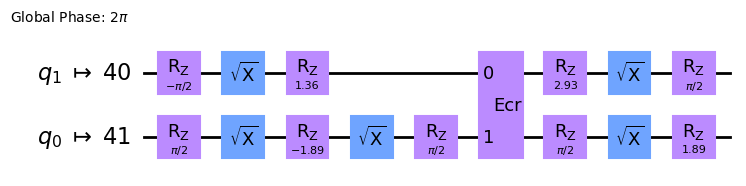

In [5]:
from qiskit import QuantumCircuit, QuantumRegister

qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)

a, b = qubits
circuit.h(a)
circuit.cx(a, b)

transpiled = pass_manager.run(circuit)

transpiled.draw("mpl", idle_wires=False)

In [6]:
from qiskit.transpiler.passes.synthesis.plugin import HighLevelSynthesisPluginManager

HighLevelSynthesisPluginManager().method_names("clifford")

['ag', 'bm', 'default', 'greedy', 'layers', 'lnn']

## Creating a plugin